# **DeepLandforms**

Author: giacomo.nodjoumi@hyranet.info - g.nodjoumi@jacobs-university.de

## DeepLandforms Training

With this notebook, users can train instance segmentation models on custom dataset of georeferenced images.
The models are based on state-of-the-art general purpose architectures, available [here](https://github.com/facebookresearch/detectron2).
Despite several types of networks are supported, such as object detection, image segmentation ad instance segmentation, and available in the above repository, this notebook and the complementary **DeepLandrorms-Segmentation** notebook are specific for instance segmentation architectures for georefernced images.

## Usage

* Prepare the dataset in COCO label format, using provided **LabelMe** container or else.
* Put or link the dataset into the **DeepLandforms** *.env* file
* Run docker-compose up
* Edit the *configs* section by editing the following parameters:
------------------------------------------------------------------
| **Parameter** | **Function** | **Common Values** |
| ---- | ---- | ---- |
| **cfg.merge_from_file(model_zoo.get_config_file(""))** | Model Architecture | MASK-R-CNN in this work |
| **cfg.TEST.EVAL_PERIOD** |  N° of epochs after an evaluation is performed | depending on SOLVER.MAX_ITER, usually every 1/10 of ITER, e.g. every 1000 on a 10000 iter |
| **cfg.DATALOADER.NUM_WORKERS** | Number of workers for dataloader | usually correspond to cpu cores |
| **cfg.MODEL.WEIGHTS** | model_zoo.get_checkpoint_url("") | Optional but advised to start from a pretrained model from the model zoo, MUST be of the same architecture of the get_config_file. see default values as example. |
| **cfg.SOLVER.IMS_PER_BATCH** | How many image to be ingested, depends on the performance of the GPU, especiall VRAM |  up to 8 for 8GB VRAM |
| **cfg.SOLVER.BASE_LR** | learning rate | 0.0002 is a good starting point |
| **cfg.SOLVER.MAX_ITER** | N° of epochs | Rise up for low mAP, lower to prevent overfitting |
| **cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE** | parameter to sample a subset of proposals coming out of RPN to calculate cls and reg loss during training. | multiple of 2, commonly 64 |
------------------------------------------------------------------
Then just execute the notebook and monitor the training in **Tensorboard** container.

## Funding
*This study is within the Europlanet 2024 RI and EXPLORE project, and it has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement No 871149 and No 101004214.*

------------------------------------------------------------------

In [1]:
import cv2
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
%matplotlib inline
from matplotlib import pyplot as plt
import os
import random
import torch
from utils.detectron_utils import Trainer
from utils.train_utils import categories_gen, classes_distribution, dataframes_gen, dataMover, getmeta, classDump, label2coco, dsReg, trainaugmenter
from detectron2.evaluation import COCOEvaluator
import labelme2coco
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog
from colour import Color
import json
from detectron2.data.catalog import Metadata
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from utils.GenUtils import get_paths, folder_file_size, chunk_creator
import rasterio as rio
from os.path import exists

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)
torch.cuda.is_available()
torch.cuda.get_device_name()

1.12.1+cu116


'NVIDIA GeForce RTX 2070 with Max-Q Design'

In [3]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [3]:
#basepath = 'Boulders/filtered_in/'
#basepath = 'WorkingDataset/MarsPIT/extracted-1/'
basepath = 'extracted-5'
home_dir = '/home/user/data/'
src_path = f'{home_dir}/{basepath}'
image_path = f'{home_dir}{basepath}'
base_dir = src_path +'/train'
#train_dir = f'{image_path}/train'
if os.path.isdir(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(base_dir)

In [4]:
train_path = f'{image_path}/train_data'
if os.path.isdir(train_path):
    shutil.rmtree(train_path)
valid_path = f'{image_path}/valid_data'
if os.path.isdir(valid_path):
    shutil.rmtree(valid_path)
test_path = f'{image_path}/test_data'
if os.path.isdir(test_path):
    shutil.rmtree(test_path)


In [5]:
dataset_name = 'dataset.json'
dataset_path = f'{src_path}/{dataset_name}'
dataset_path
if exists(dataset_path):
    os.remove(dataset_path)
    
dataset, dataset_meta, dataset_classes = dsReg(f'{src_path}', dataset_name, base_dir)

There are 482 listed files in folder extracted-5.


Converting labelme annotations to COCO format: 100%|██████████| 482/482 [00:00<00:00, 1453.18it/s]
10/21/2022 10:28:09 - INFO - labelme2coco -   Converted annotations in COCO format is exported to /home/user/data/extracted-5/dataset.json
10/21/2022 10:28:09 - WARNING - detectron2.data.datasets.coco -   
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

10/21/2022 10:28:09 - INFO - detectron2.data.datasets.coco -   Loaded 482 images in COCO format from /home/user/data//extracted-5/dataset.json


In [6]:
train_df_dis, valid_df_dis, test_df_dis, train, valid, test = dataframes_gen(dataset_classes, dataset, 0.65,0.15)

In [7]:
dataMover(image_path, train, valid, test)

In [8]:
trainaugmenter(f'{image_path}/train_data',f'{image_path}/train_data')

Generating Images: 100%|██████████| 168/168 [00:04<00:00, 36.56File/s]


In [9]:
train_name = 'dataset.json'
train_path = f'{image_path}/train_data'
train_json = f'{train_path}/{train_name}'
if exists(train_json):
    os.remove(train_json)
train, train_meta, train_classes = dsReg(train_path, 'traindata', train_path)

There are 1008 listed files in folder train_data.


Converting labelme annotations to COCO format: 100%|██████████| 1008/1008 [00:00<00:00, 1289.73it/s]
10/21/2022 10:28:20 - INFO - labelme2coco -   Converted annotations in COCO format is exported to /home/user/data/extracted-5/train_data/dataset.json
10/21/2022 10:28:20 - WARNING - detectron2.data.datasets.coco -   
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

10/21/2022 10:28:20 - INFO - detectron2.data.datasets.coco -   Loaded 1008 images in COCO format from /home/user/data/extracted-5/train_data/dataset.json


In [10]:
valid_name = 'dataset.json'
valid_path = f'{image_path}/valid_data'
valid_json = f'{valid_path}/{valid_name}'
if exists(valid_json):
    os.remove(valid_json)
valid, valid_meta, valid_classes = dsReg(valid_path, 'valid_data', valid_path)

There are 266 listed files in folder valid_data.


Converting labelme annotations to COCO format: 100%|██████████| 266/266 [00:00<00:00, 1363.49it/s]
10/21/2022 10:28:21 - INFO - labelme2coco -   Converted annotations in COCO format is exported to /home/user/data/extracted-5/valid_data/dataset.json
10/21/2022 10:28:21 - WARNING - detectron2.data.datasets.coco -   
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

10/21/2022 10:28:21 - INFO - detectron2.data.datasets.coco -   Loaded 266 images in COCO format from /home/user/data/extracted-5/valid_data/dataset.json


In [11]:
test_name = 'dataset.json'
test_path = f'{image_path}/test_data'
test_json = f'{test_path}/{test_name}'
if exists(test_json):
    os.remove(test_json)
test, test_meta, test_classes = dsReg(test_path, 'test_data', test_path)

There are 48 listed files in folder test_data.


Converting labelme annotations to COCO format: 100%|██████████| 48/48 [00:00<00:00, 1067.59it/s]
10/21/2022 10:28:21 - INFO - labelme2coco -   Converted annotations in COCO format is exported to /home/user/data/extracted-5/test_data/dataset.json
10/21/2022 10:28:21 - WARNING - detectron2.data.datasets.coco -   
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

10/21/2022 10:28:21 - INFO - detectron2.data.datasets.coco -   Loaded 48 images in COCO format from /home/user/data/extracted-5/test_data/dataset.json


In [12]:
import pandas as pd
def clsdis(categories, datatype, classes):    
    classes_dis=[]
    for cat in categories:
    #    print(classes[cat])
        classes_dis.append(classes[cat])
    classes_dis =list(zip(classes_dis,[datatype for i in range(len(classes_dis))]))
    df_dis = pd.DataFrame(classes_dis, columns=['Class','Dataset'])
    return df_dis

In [14]:
train_cat = categories_gen(train)
train_df_dis = clsdis(train_cat, 'Train', train_classes)

Text(0.5, 1.0, 'Test Dataset\n48 Labels')

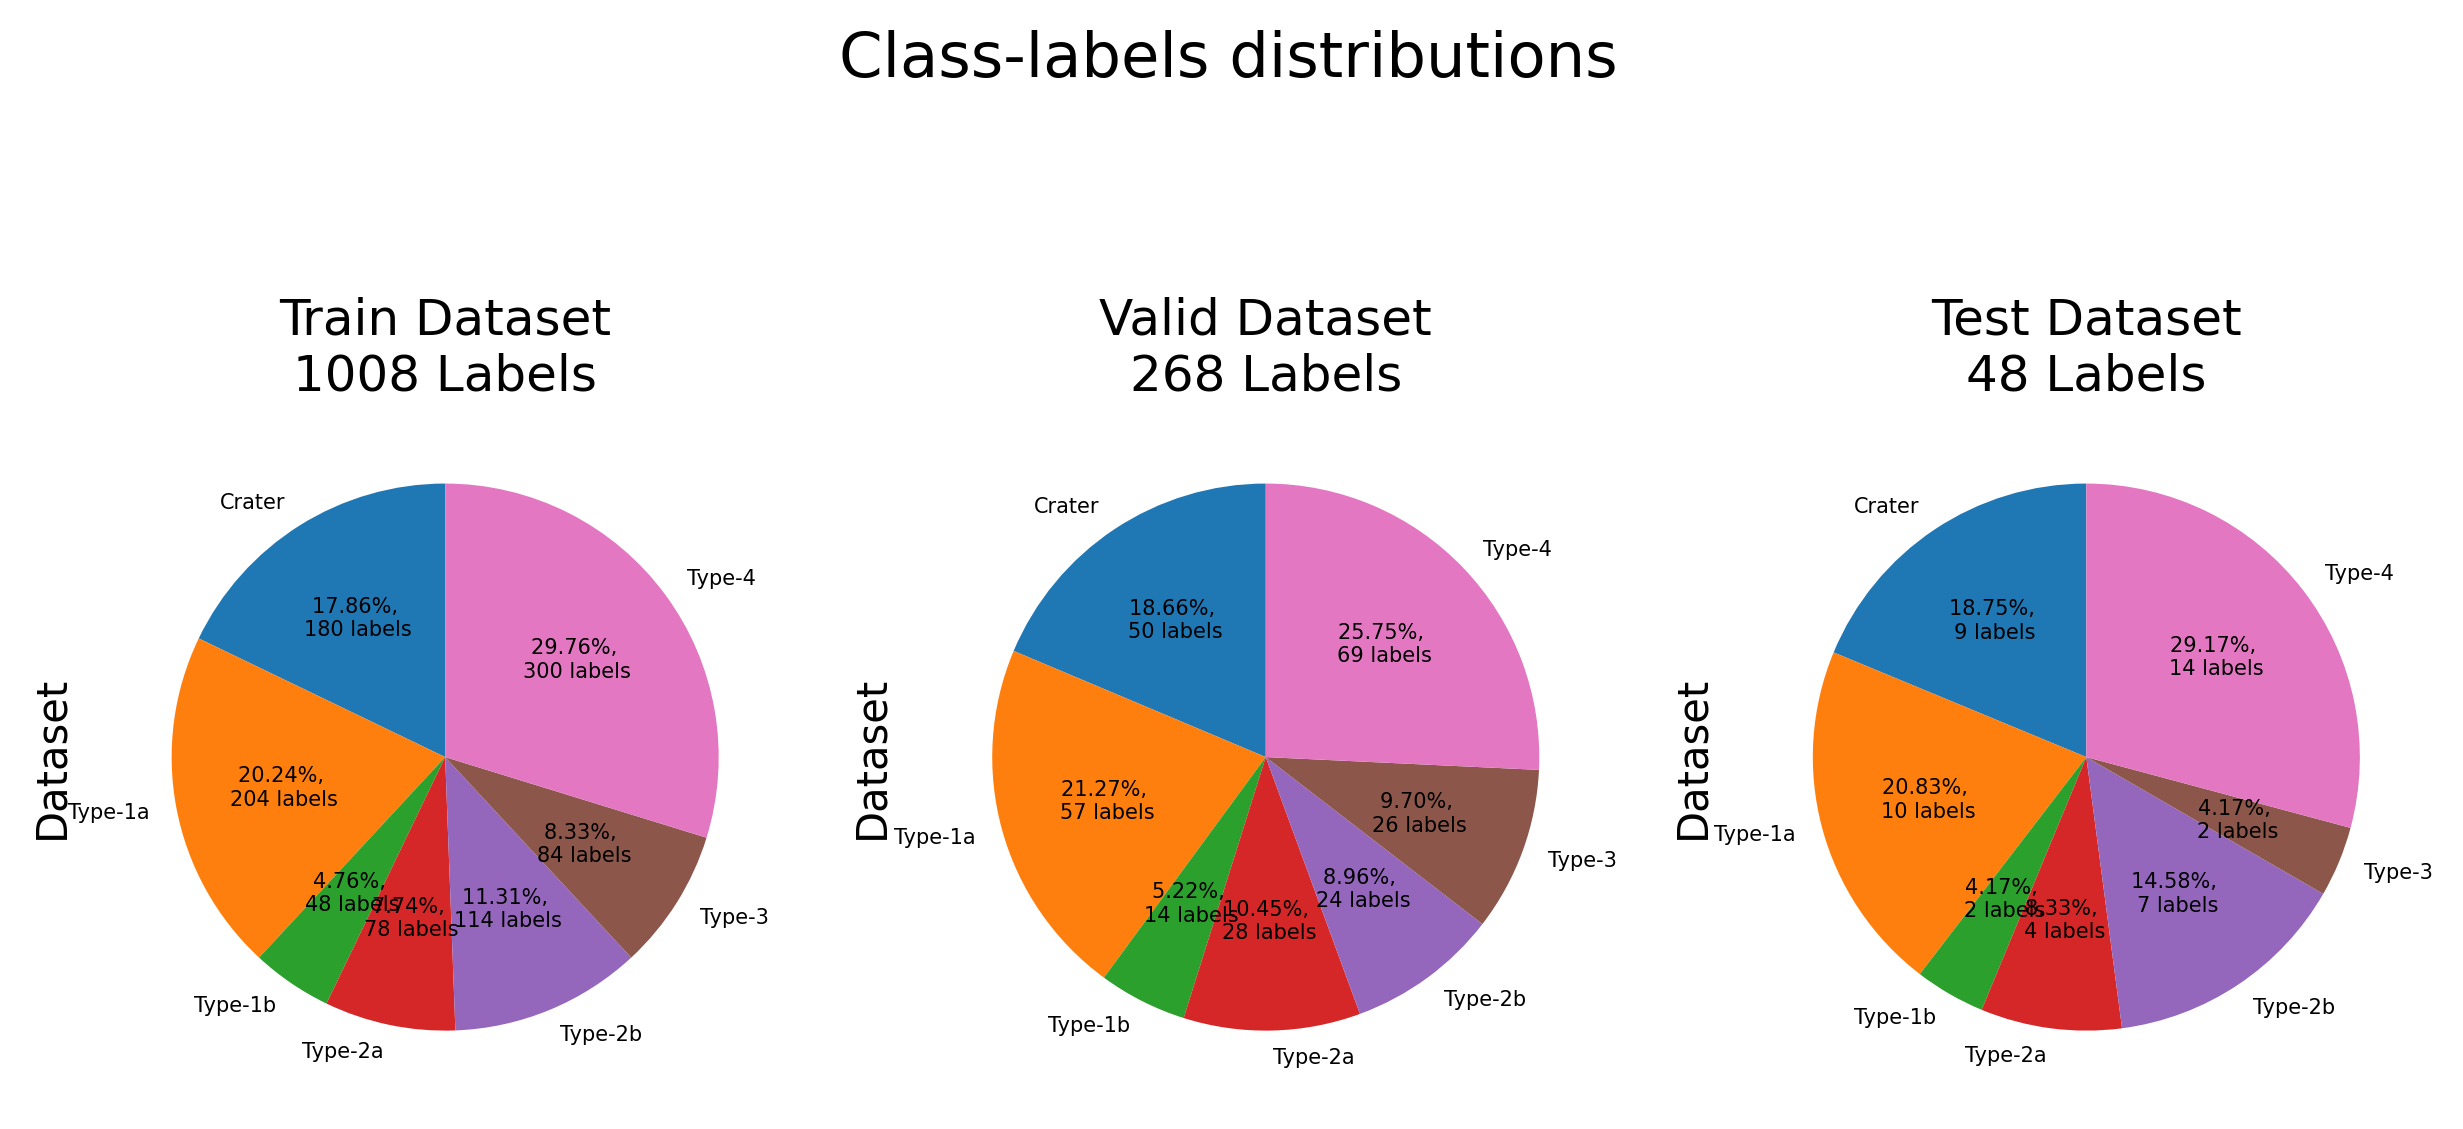

In [15]:
label = dataset_classes
plt.figure(figsize = (10,5), facecolor='white',dpi=300)
plt.suptitle('Class-labels distributions', fontsize=15)
ax1 = plt.subplot(131)
train_df_dis.groupby(['Class']).count().plot(kind='pie', figsize=(10,1,0), autopct=lambda p:f'{p:.2f}%, \n{p*len(train_df_dis)/100:.0f} labels',startangle=90, subplots=True, ax =ax1, fontsize=5, legend=False)
plt.title('Train Dataset\n{} Labels'.format(len(train_df_dis), loc='center'))
ax2 = plt.subplot(132)
valid_df_dis.groupby(['Class']).count().plot(kind='pie', figsize=(10,10),autopct=lambda p:f'{p:.2f}%, \n{p*len(valid_df_dis)/100:.0f} labels',startangle=90, subplots=True, ax =ax2, fontsize=5,legend=False)
plt.title('Valid Dataset\n{} Labels'.format(len(valid_df_dis), loc='center', ))
ax3 = plt.subplot(133)
test_df_dis.groupby(['Class']).count().plot(kind='pie', figsize=(10,10),autopct=lambda p:f'{p:.2f}%, \n{p*len(test_df_dis)/100:.0f} labels',startangle=90, subplots=True, ax =ax3, fontsize=5,legend=False)
plt.title('Test Dataset\n{} Labels'.format(len(test_df_dis), loc='center', ))

**CONFIGS - edit befor run**

In [16]:
cfg = get_cfg()
#model_config='mask_rcnn_R_50_C4_1x.yaml'
model_config='mask_rcnn_R_50_FPN_3x.yaml'
#model_config='mask_rcnn_R_101_FPN_3x.yaml'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/"+model_config))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('traindata',)
cfg.DATASETS.TEST = ('valid_data',)
cfg.TEST.EVAL_PERIOD = 500
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/"+model_config)  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.MASK_ON = True
cfg.SOLVER.IMS_PER_BATCH = 2
#cfg.SOLVER.BASE_LR = 0.001
#cfg.SOLVER.BASE_LR = 0.00025
#cfg.SOLVER.BASE_LR = 0.0015
#cfg.SOLVER.WARMUP_ITERS = 1000
#cfg.SOLVER.MAX_ITER = 10000 #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.CHECKPOINT_PERIOD= 2500
#cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
#cfg.SOLVER.MAX_ITER = 10000  # and a good number of iterations
#cfg.SOLVER.STEPS = (6000, 7000, 8000,9000) 

cfg.SOLVER.CHECKPOINT_PERIOD = 2500  # Save a checkpoint after every this number of iterations
cfg.SOLVER.MAX_ITER = 5000 

# Weight decay
cfg.SOLVER.BASE_LR = 0.050  # learning rate
cfg.SOLVER.GAMMA = 0.0025
# The iteration number to decrease learning rate by GAMMA.
cfg.SOLVER.STEPS = (1000,)#, 5000, 10000)

# Don't scale the input images
#cfg.INPUT.MIN_SIZE_TRAIN = 900
#cfg.INPUT.MAX_SIZE_TRAIN = 900
#cfg.INPUT.MIN_SIZE_TEST = 900
#cfg.INPUT.MAX_SIZE_TEST = 900
#cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p3', 'p4', 'p5', 'p6']
#cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0, 2.0, 4.0, 8.0]]
#cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[4], [8], [16], [64], [128]]
#cfg.MODEL.PIXEL_MEAN = [58.33, 58.33, 58.33] 
#cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 10000
#cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.7
#cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.5] # Intersection over union threshold
#cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 10000  # originally 1000
#cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 10000  # originally 1000


# Solver
#cfg.SOLVER.IMS_PER_BATCH = 8
#cfg.SOLVER.BASE_LR = 0.001
#cfg.SOLVER.BASE_LR = 0.00025
#cfg.SOLVER.BASE_LR = 0.0001
#cfg.SOLVER.WARMUP_ITERS = 1000
#cfg.SOLVER.MAX_ITER = 15000 #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.CHECKPOINT_PERIOD= 2500
#cfg.SOLVER.WARMUP_ITERS = 1000
#cfg.SOLVER.STEPS = (200,400,600, 800)
#cfg.SOLVER.GAMMA = 0.05
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =  1024
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(train_classes)  
cfg.OUTPUT_DIR = base_dir
#cfg.INPUT.MIN_SIZE_TRAIN = 32
#cfg.INPUT.MAX_SIZE_TRAIN = 32
#cfg.INPUT.MIN_SIZE_TEST = 32
#cfg.INPUT.MAX_SIZE_TEST = 32
cfg.SOLVER.AMP.ENABLED=True



**End of configs**

/home/user/data/extracted-5/train_data/ESP_027105_1740_RED_resized_5_lbl_0_noised_sigma_0.15_.tiff


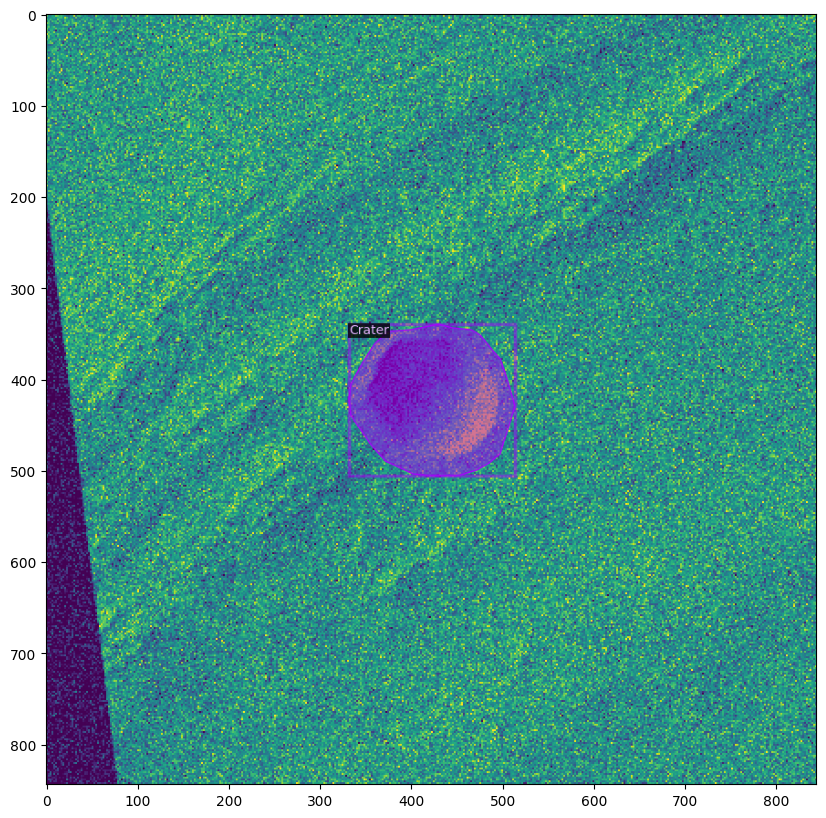

In [17]:
for d in random.sample(train, 1):
    #srpath = f'{image_path}/train_data/'
    img_path = d["file_name"]
    print(img_path)
    img = cv2.imread(img_path)
    visualizer = Visualizer(img[:, :, 1:-1], metadata=train_meta, scale=2)
    out = visualizer.draw_dataset_dict(d)
    fig = plt.figure(figsize=(10,10))
    plt.imshow(out.get_image()[:, :, :])

In [18]:
# RUN
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)

10/21/2022 10:28:41 - INFO - detectron2.engine.defaults -   Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
     

%load_ext tensorboard
%tensorboard --logdir {base_dir}

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
trainer.resume_or_load(resume=False)
trainer.train()

10/21/2022 10:28:49 - INFO - fvcore.common.checkpoint -   [Checkpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
10/21/2022 10:28:49 - INFO - iopath.common.file_io -   Downloading https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
10/21/2022 10:28:49 - INFO - iopath.common.download -   Downloading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
model_final_f10217.pkl: 178MB [00:11, 15.0MB/s]                              
10/21/2022 10:29:01 - INFO - iopath.common.download -   Successfully downloaded /home/user/.torch/iopath_cache/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl. 177841981 bytes.
10/21/2022 10:29:01 - INFO - iopath.common.file_io -   URL https://dl.fbaipublicfiles.com/dete

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.

10/21/2022 10:31:33 - INFO - detectron2.evaluation.fast_eval_api -   Evaluate annotation type *segm*


Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!


10/21/2022 10:31:34 - INFO - detectron2.evaluation.fast_eval_api -   COCOeval_opt.evaluate() finished in 0.18 seconds.
10/21/2022 10:31:34 - INFO - detectron2.evaluation.fast_eval_api -   Accumulating evaluation results...
10/21/2022 10:31:34 - INFO - detectron2.evaluation.fast_eval_api -   COCOeval_opt.accumulate() finished in 0.03 seconds.
10/21/2022 10:31:34 - INFO - detectron2.evaluation.coco_evaluation -   Evaluation results for segm: 
|  AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:-----:|:------:|:------:|:-----:|:-----:|:------:|
| 4.168 | 5.693  | 4.821  | 3.295 | 5.633 | 17.064 |
10/21/2022 10:31:34 - INFO - detectron2.evaluation.coco_evaluation -   Per-category segm AP: 
| category   | AP    | category   | AP    | category   | AP    |
|:-----------|:------|:-----------|:------|:-----------|:------|
| Type-1a    | 3.063 | Crater     | 5.727 | Type-4     | 7.403 |
| Type-3     | 0.208 | Type-2b    | 2.569 | Type-1b    | 4.257 |
| Type-2a    | 5.952 |            |       

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.562


10/21/2022 10:31:34 - INFO - utils.detectron_utils -   Loss on Validation  done 11/266. 0.0000 s / img. ETA=0:00:13
10/21/2022 10:31:39 - INFO - utils.detectron_utils -   Loss on Validation  done 85/266. 0.0000 s / img. ETA=0:00:12
10/21/2022 10:31:44 - INFO - utils.detectron_utils -   Loss on Validation  done 158/266. 0.0000 s / img. ETA=0:00:07
10/21/2022 10:31:49 - INFO - utils.detectron_utils -   Loss on Validation  done 230/266. 0.0000 s / img. ETA=0:00:02
10/21/2022 10:31:52 - INFO - detectron2.utils.events -    eta: 0:21:50  iter: 499  total_loss: 0.4686  loss_cls: 0.1403  loss_box_reg: 0.1419  loss_mask: 0.1759  loss_rpn_cls: 0.0005638  loss_rpn_loc: 0.004069  validation_loss: 0.5171  time: 0.2504  data_time: 0.0034  lr: 8.7425e-05  max_mem: 2246M
10/21/2022 10:31:58 - INFO - detectron2.utils.events -    eta: 0:21:47  iter: 519  total_loss: 0.4788  loss_cls: 0.1413  loss_box_reg: 0.1436  loss_mask: 0.1784  loss_rpn_cls: 0.001647  loss_rpn_loc: 0.004096  validation_loss: 0.5171 

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.

10/21/2022 10:34:33 - INFO - detectron2.evaluation.fast_eval_api -   Evaluate annotation type *segm*
10/21/2022 10:34:33 - INFO - detectron2.evaluation.fast_eval_api -   COCOeval_opt.evaluate() finished in 0.09 seconds.
10/21/2022 10:34:33 - INFO - detectron2.evaluation.fast_eval_api -   Accumulating evaluation results...
10/21/2022 10:34:33 - INFO - detectron2.evaluation.fast_eval_api -   COCOeval_opt.accumulate() finished in 0.03 seconds.
10/21/2022 10:34:33 - INFO - detectron2.evaluation.coco_evaluation -   Evaluation results for segm: 
|  AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:-----:|:------:|:------:|:-----:|:-----:|:------:|
| 7.204 | 9.921  | 8.776  | 6.612 | 8.432 | 17.181 |
10/21/2022 10:34:33 - INFO - detectron2.evaluation.coco_evaluation -   Per-category segm AP: 
| category   | AP    | category   | AP     | category   | AP     |
|:-----------|:------|:-----------|:-------|:-----------|:-------|
| Type-1a    | 2.922 | Crater     | 6.753  | Type-4     | 16.799 |


Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.

10/21/2022 10:34:34 - INFO - utils.detectron_utils -   Loss on Validation  done 11/266. 0.0000 s / img. ETA=0:00:14
10/21/2022 10:34:39 - INFO - utils.detectron_utils -   Loss on Validation  done 80/266. 0.0000 s / img. ETA=0:00:13
10/21/2022 10:34:44 - INFO - utils.detectron_utils -   Loss on Validation  done 147/266. 0.0000 s / img. ETA=0:00:08
10/21/2022 10:34:49 - INFO - utils.detectron_utils -   Loss on Validation  done 216/266. 0.0000 s / img. ETA=0:00:03
10/21/2022 10:34:53 - INFO - detectron2.utils.events -    eta: 0:19:41  iter: 999  total_loss: 0.4338  loss_cls: 0.1459  loss_box_reg: 0.1295  loss_mask: 0.1142  loss_rpn_cls: 0.002263  loss_rpn_loc: 0.002947  validation_loss: 0.5051  time: 0.2609  data_time: 0.0034  lr: 0.00012493  max_mem: 2246M
10/21/2022 10:34:59 - INFO - detectron2.utils.events -    eta: 0:19:36  iter: 1019  total_loss: 0.4416  loss_cls: 0.1223  loss_box_reg: 0.1263  loss_mask: 0.1411  loss_rpn_cls: 0.0008411  loss_rpn_loc: 0.003329  validation_loss: 0.5051

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.

10/21/2022 10:37:39 - INFO - detectron2.evaluation.fast_eval_api -   COCOeval_opt.evaluate() finished in 0.11 seconds.
10/21/2022 10:37:39 - INFO - detectron2.evaluation.fast_eval_api -   Accumulating evaluation results...
10/21/2022 10:37:39 - INFO - detectron2.evaluation.fast_eval_api -   COCOeval_opt.accumulate() finished in 0.03 seconds.
10/21/2022 10:37:39 - INFO - detectron2.evaluation.coco_evaluation -   Evaluation results for segm: 
|  AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:-----:|:------:|:------:|:-----:|:-----:|:------:|
| 6.477 | 8.984  | 7.895  | 4.000 | 8.066 | 14.236 |
10/21/2022 10:37:39 - INFO - detectron2.evaluation.coco_evaluation -   Per-category segm AP: 
| category   | AP    | category   | AP     | category   | AP     |
|:-----------|:------|:-----------|:-------|:-----------|:-------|
| Type-1a    | 1.524 | Crater     | 8.362  | Type-4     | 15.875 |
| Type-3     | 4.503 | Type-2b    | 13.299 | Type-1b    | 0.218  |
| Type-2a    | 1.562 |            

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.567


10/21/2022 10:37:40 - INFO - utils.detectron_utils -   Loss on Validation  done 11/266. 0.0000 s / img. ETA=0:00:15
10/21/2022 10:37:45 - INFO - utils.detectron_utils -   Loss on Validation  done 75/266. 0.0000 s / img. ETA=0:00:14
10/21/2022 10:37:50 - INFO - utils.detectron_utils -   Loss on Validation  done 137/266. 0.0000 s / img. ETA=0:00:10
10/21/2022 10:37:55 - INFO - utils.detectron_utils -   Loss on Validation  done 200/266. 0.0000 s / img. ETA=0:00:05
10/21/2022 10:38:00 - INFO - utils.detectron_utils -   Loss on Validation  done 265/266. 0.0000 s / img. ETA=0:00:00
10/21/2022 10:38:01 - INFO - detectron2.utils.events -    eta: 0:18:06  iter: 1499  total_loss: 0.3491  loss_cls: 0.1167  loss_box_reg: 0.09263  loss_mask: 0.126  loss_rpn_cls: 0.0009392  loss_rpn_loc: 0.003929  validation_loss: 0.4932  time: 0.2677  data_time: 0.0034  lr: 0.000125  max_mem: 2246M
10/21/2022 10:38:06 - INFO - detectron2.utils.events -    eta: 0:17:59  iter: 1519  total_loss: 0.326  loss_cls: 0.107

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.

10/21/2022 10:40:48 - INFO - detectron2.evaluation.coco_evaluation -   Evaluation results for segm: 
|  AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:-----:|:------:|:------:|:-----:|:-----:|:------:|
| 6.905 | 9.600  | 7.813  | 3.539 | 9.756 | 10.752 |
10/21/2022 10:40:48 - INFO - detectron2.evaluation.coco_evaluation -   Per-category segm AP: 
| category   | AP    | category   | AP     | category   | AP     |
|:-----------|:------|:-----------|:-------|:-----------|:-------|
| Type-1a    | 2.076 | Crater     | 7.766  | Type-4     | 11.927 |
| Type-3     | 6.309 | Type-2b    | 19.891 | Type-1b    | 0.033  |
| Type-2a    | 0.332 |            |        |            |        |
10/21/2022 10:40:48 - INFO - detectron2.engine.defaults -   Evaluation results for valid_data in csv format:
10/21/2022 10:40:48 - INFO - detectron2.evaluation.testing -   copypaste: Task: bbox
10/21/2022 10:40:48 - INFO - detectron2.evaluation.testing -   copypaste: AP,AP50,AP75,APs,APm,APl
10/21/2022 10:40:4

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.571
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.405


10/21/2022 10:40:49 - INFO - utils.detectron_utils -   Loss on Validation  done 11/266. 0.0000 s / img. ETA=0:00:14
10/21/2022 10:40:54 - INFO - utils.detectron_utils -   Loss on Validation  done 74/266. 0.0000 s / img. ETA=0:00:14
10/21/2022 10:40:59 - INFO - utils.detectron_utils -   Loss on Validation  done 138/266. 0.0000 s / img. ETA=0:00:10
10/21/2022 10:41:04 - INFO - utils.detectron_utils -   Loss on Validation  done 203/266. 0.0000 s / img. ETA=0:00:04
10/21/2022 10:41:09 - INFO - detectron2.utils.events -    eta: 0:16:20  iter: 1999  total_loss: 0.3038  loss_cls: 0.1063  loss_box_reg: 0.06549  loss_mask: 0.1205  loss_rpn_cls: 0.0004729  loss_rpn_loc: 0.003175  validation_loss: 0.4872  time: 0.2725  data_time: 0.0036  lr: 0.000125  max_mem: 2246M
10/21/2022 10:41:15 - INFO - detectron2.utils.events -    eta: 0:16:13  iter: 2019  total_loss: 0.3142  loss_cls: 0.1029  loss_box_reg: 0.08014  loss_mask: 0.1255  loss_rpn_cls: 0.0003455  loss_rpn_loc: 0.003142  validation_loss: 0.48

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.

10/21/2022 10:44:01 - INFO - detectron2.evaluation.fast_eval_api -   Accumulating evaluation results...
10/21/2022 10:44:01 - INFO - detectron2.evaluation.fast_eval_api -   COCOeval_opt.accumulate() finished in 0.03 seconds.
10/21/2022 10:44:01 - INFO - detectron2.evaluation.coco_evaluation -   Evaluation results for segm: 
|  AP   |  AP50  |  AP75  |  APs  |  APm   |  APl   |
|:-----:|:------:|:------:|:-----:|:------:|:------:|
| 8.317 | 11.614 | 9.823  | 3.957 | 10.990 | 17.123 |
10/21/2022 10:44:01 - INFO - detectron2.evaluation.coco_evaluation -   Per-category segm AP: 
| category   | AP    | category   | AP     | category   | AP     |
|:-----------|:------|:-----------|:-------|:-----------|:-------|
| Type-1a    | 0.715 | Crater     | 9.337  | Type-4     | 16.388 |
| Type-3     | 7.398 | Type-2b    | 23.877 | Type-1b    | 0.000  |
| Type-2a    | 0.500 |            |        |            |        |
10/21/2022 10:44:01 - INFO - detectron2.engine.defaults -   Evaluation results for 

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.575
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.524


10/21/2022 10:44:02 - INFO - utils.detectron_utils -   Loss on Validation  done 11/266. 0.0000 s / img. ETA=0:00:14
10/21/2022 10:44:07 - INFO - utils.detectron_utils -   Loss on Validation  done 73/266. 0.0000 s / img. ETA=0:00:15
10/21/2022 10:44:12 - INFO - utils.detectron_utils -   Loss on Validation  done 139/266. 0.0000 s / img. ETA=0:00:09
10/21/2022 10:44:17 - INFO - utils.detectron_utils -   Loss on Validation  done 205/266. 0.0000 s / img. ETA=0:00:04
10/21/2022 10:44:22 - INFO - detectron2.utils.events -    eta: 0:13:46  iter: 2499  total_loss: 0.3082  loss_cls: 0.09758  loss_box_reg: 0.06239  loss_mask: 0.1103  loss_rpn_cls: 0.0001103  loss_rpn_loc: 0.003189  validation_loss: 0.4812  time: 0.2762  data_time: 0.0036  lr: 0.000125  max_mem: 2246M
10/21/2022 10:44:28 - INFO - detectron2.utils.events -    eta: 0:13:43  iter: 2519  total_loss: 0.3088  loss_cls: 0.1061  loss_box_reg: 0.07813  loss_mask: 0.0998  loss_rpn_cls: 8.876e-05  loss_rpn_loc: 0.002637  validation_loss: 0.4

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.

10/21/2022 10:47:10 - INFO - detectron2.evaluation.coco_evaluation -   Evaluation results for segm: 
|  AP   |  AP50  |  AP75  |  APs  |  APm   |  APl   |
|:-----:|:------:|:------:|:-----:|:------:|:------:|
| 7.871 | 10.914 | 9.098  | 4.393 | 10.291 | 18.737 |
10/21/2022 10:47:10 - INFO - detectron2.evaluation.coco_evaluation -   Per-category segm AP: 
| category   | AP    | category   | AP     | category   | AP     |
|:-----------|:------|:-----------|:-------|:-----------|:-------|
| Type-1a    | 0.720 | Crater     | 6.859  | Type-4     | 14.253 |
| Type-3     | 7.373 | Type-2b    | 24.652 | Type-1b    | 0.000  |
| Type-2a    | 1.240 |            |        |            |        |
10/21/2022 10:47:10 - INFO - detectron2.engine.defaults -   Evaluation results for valid_data in csv format:
10/21/2022 10:47:10 - INFO - detectron2.evaluation.testing -   copypaste: Task: bbox
10/21/2022 10:47:10 - INFO - detectron2.evaluation.testing -   copypaste: AP,AP50,AP75,APs,APm,APl
10/21/2022 10:4

 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.479


10/21/2022 10:47:11 - INFO - utils.detectron_utils -   Loss on Validation  done 11/266. 0.0000 s / img. ETA=0:00:15
10/21/2022 10:47:16 - INFO - utils.detectron_utils -   Loss on Validation  done 78/266. 0.0000 s / img. ETA=0:00:13
10/21/2022 10:47:21 - INFO - utils.detectron_utils -   Loss on Validation  done 144/266. 0.0000 s / img. ETA=0:00:09
10/21/2022 10:47:26 - INFO - utils.detectron_utils -   Loss on Validation  done 209/266. 0.0000 s / img. ETA=0:00:04
10/21/2022 10:47:31 - INFO - detectron2.utils.events -    eta: 0:11:07  iter: 2999  total_loss: 0.2853  loss_cls: 0.1096  loss_box_reg: 0.08372  loss_mask: 0.1  loss_rpn_cls: 7.19e-05  loss_rpn_loc: 0.003246  validation_loss: 0.4872  time: 0.2783  data_time: 0.0038  lr: 0.000125  max_mem: 2246M
10/21/2022 10:47:37 - INFO - detectron2.utils.events -    eta: 0:11:01  iter: 3019  total_loss: 0.317  loss_cls: 0.1122  loss_box_reg: 0.0824  loss_mask: 0.1251  loss_rpn_cls: 4.978e-05  loss_rpn_loc: 0.002975  validation_loss: 0.4872  ti

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.

10/21/2022 10:50:19 - INFO - detectron2.evaluation.coco_evaluation -   Evaluation results for segm: 
|  AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:-----:|:------:|:------:|:-----:|:-----:|:------:|
| 8.075 | 11.092 | 9.713  | 7.363 | 9.570 | 16.386 |
10/21/2022 10:50:19 - INFO - detectron2.evaluation.coco_evaluation -   Per-category segm AP: 
| category   | AP    | category   | AP     | category   | AP     |
|:-----------|:------|:-----------|:-------|:-----------|:-------|
| Type-1a    | 0.696 | Crater     | 4.733  | Type-4     | 15.014 |
| Type-3     | 7.858 | Type-2b    | 27.220 | Type-1b    | 0.000  |
| Type-2a    | 1.001 |            |        |            |        |
10/21/2022 10:50:19 - INFO - detectron2.engine.defaults -   Evaluation results for valid_data in csv format:
10/21/2022 10:50:19 - INFO - detectron2.evaluation.testing -   copypaste: Task: bbox
10/21/2022 10:50:19 - INFO - detectron2.evaluation.testing -   copypaste: AP,AP50,AP75,APs,APm,APl
10/21/2022 10:50:1

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.498


10/21/2022 10:50:20 - INFO - utils.detectron_utils -   Loss on Validation  done 11/266. 0.0000 s / img. ETA=0:00:16
10/21/2022 10:50:25 - INFO - utils.detectron_utils -   Loss on Validation  done 76/266. 0.0000 s / img. ETA=0:00:14
10/21/2022 10:50:30 - INFO - utils.detectron_utils -   Loss on Validation  done 141/266. 0.0000 s / img. ETA=0:00:09
10/21/2022 10:50:35 - INFO - utils.detectron_utils -   Loss on Validation  done 205/266. 0.0000 s / img. ETA=0:00:04
10/21/2022 10:50:40 - INFO - detectron2.utils.events -    eta: 0:08:19  iter: 3499  total_loss: 0.2938  loss_cls: 0.09213  loss_box_reg: 0.07348  loss_mask: 0.1176  loss_rpn_cls: 9.855e-05  loss_rpn_loc: 0.003234  validation_loss: 0.4932  time: 0.2796  data_time: 0.0036  lr: 0.000125  max_mem: 2246M
10/21/2022 10:50:46 - INFO - detectron2.utils.events -    eta: 0:08:13  iter: 3519  total_loss: 0.2767  loss_cls: 0.08057  loss_box_reg: 0.06926  loss_mask: 0.1172  loss_rpn_cls: 0.0002822  loss_rpn_loc: 0.002287  validation_loss: 0.

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.

10/21/2022 10:53:27 - INFO - detectron2.evaluation.fast_eval_api -   COCOeval_opt.evaluate() finished in 0.06 seconds.
10/21/2022 10:53:27 - INFO - detectron2.evaluation.fast_eval_api -   Accumulating evaluation results...
10/21/2022 10:53:27 - INFO - detectron2.evaluation.fast_eval_api -   COCOeval_opt.accumulate() finished in 0.03 seconds.
10/21/2022 10:53:27 - INFO - detectron2.evaluation.coco_evaluation -   Evaluation results for segm: 
|  AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:-----:|:------:|:------:|:-----:|:-----:|:------:|
| 8.194 | 11.094 | 9.835  | 6.479 | 9.148 | 18.653 |
10/21/2022 10:53:27 - INFO - detectron2.evaluation.coco_evaluation -   Per-category segm AP: 
| category   | AP    | category   | AP     | category   | AP     |
|:-----------|:------|:-----------|:-------|:-----------|:-------|
| Type-1a    | 0.313 | Crater     | 4.786  | Type-4     | 15.860 |
| Type-3     | 4.721 | Type-2b    | 30.239 | Type-1b    | 0.000  |
| Type-2a    | 1.442 |            

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.474


10/21/2022 10:53:28 - INFO - utils.detectron_utils -   Loss on Validation  done 11/266. 0.0000 s / img. ETA=0:00:16
10/21/2022 10:53:33 - INFO - utils.detectron_utils -   Loss on Validation  done 73/266. 0.0000 s / img. ETA=0:00:15
10/21/2022 10:53:38 - INFO - utils.detectron_utils -   Loss on Validation  done 136/266. 0.0000 s / img. ETA=0:00:10
10/21/2022 10:53:43 - INFO - utils.detectron_utils -   Loss on Validation  done 200/266. 0.0000 s / img. ETA=0:00:05
10/21/2022 10:53:48 - INFO - utils.detectron_utils -   Loss on Validation  done 262/266. 0.0000 s / img. ETA=0:00:00
10/21/2022 10:53:49 - INFO - detectron2.utils.events -    eta: 0:05:29  iter: 3999  total_loss: 0.2604  loss_cls: 0.08472  loss_box_reg: 0.07213  loss_mask: 0.09751  loss_rpn_cls: 4.392e-05  loss_rpn_loc: 0.002548  validation_loss: 0.4938  time: 0.2804  data_time: 0.0037  lr: 0.000125  max_mem: 2246M


In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = src_path+'/train'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')



In [ ]:
train_val = []
train_iter = []
for x in experiment_metrics:
    try:
        train_val.append(x['total_loss'])
        train_iter.append(x['iteration'])
    except:
        pass

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(
    train_iter,
    train_val)
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Total/Validation Loss', fontsize=15)

plt.savefig(f'{experiment_folder}/total_val_loss.png', dpi=300)
plt.show()